In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats import sigmaclip
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

### Функции

In [2]:
def perform_change(ar):
    uniq_val = ar.unique()
    decoder = {}
    count = 1
    for i in uniq_val:
        if pd.isna(i):
            decoder[count] = i
            count += 1
            continue
        ar.replace(i, count, inplace=True)
        decoder[count] = i
        count += 1
    return decoder

def perform_decoder(ar, decoder):
    for key, value in decoder.items():
        ar.replace(key, value, inplace=True)

In [3]:
value_for_find = ['-', ' ', -1, -9, 0, 'nan', np.nan]
def info_table(df):
    count_rows = df.shape[0]
    
    print(f"Количество строк и столбцов: {df.shape}.\n")
    
    name_columns = df.columns.tolist()
    print(f"В таблице содержатся следующие столбцы: {name_columns}.\n")

    general_count_isnull = df.isnull().sum().sum()
    
    print("Для всей таблицы:\n")

    print(f"Количество строк, в которых содержится хоть одно значение nan: {general_count_isnull}. " + 
          f"Процент от общего количества: {general_count_isnull/count_rows*100}\n")
    
    for k in value_for_find:
            if pd.isna(k): 
                count = df.isna().sum().sum()      
            else:
                count = (df == k).sum().sum()
            print(f"Значение '{k}' встречается: {count} раз. {count/count_rows*100}% от общего количества")
    print()
    
    for name in name_columns:
        print(f"Тип данных в столбце {name}: {df[name].dtype}.")
        
        print(f"Количество уникальных значений в столбце {name}: {df[name].unique().shape}")
        
        print(f"Первые двадцать уникальных значений в столбце {name}: {df[name].unique()[:20:]}")
    
        for k in value_for_find:
            if pd.isna(k): 
                count = df[name].isna().sum()        
            else:
                count = (df[name] == k).sum() 
            print(f"Значение '{k}' в столбце {name} встречается: {count} раз. {count/count_rows*100}% от общего количества")
        print()

In [4]:
def perform_change(ar):
    uniq_val = ar.unique()
    decoder = {}
    count = 1
    for i in uniq_val:
        if pd.isna(i):
            decoder[count] = i
            count += 1
            continue
        ar.replace(i, count, inplace=True)
        decoder[count] = i
        count += 1
    return decoder

def perform_decoder(ar, decoder):
    for key, value in decoder.items():
        ar.replace(key, value, inplace=True)

In [5]:
# Загрузка данных
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

### Анализ данных

In [6]:
print(data_train)
print(data_test)

     PassengerId  Survived  Pclass  \
0            486         0       3   
1            426         0       3   
2            780         1       1   
3            248         1       2   
4            184         1       2   
..           ...       ...     ...   
529          643         0       3   
530          375         0       3   
531          177         0       3   
532          438         1       2   
533          461         1       1   

                                                  Name     Sex   Age  SibSp  \
0                               Lefebre, Miss. Jeannie  female   NaN      3   
1                               Wiseman, Mr. Phillippe    male   NaN      0   
2    Robert, Mrs. Edward Scott (Elisabeth Walton Mc...  female  43.0      0   
3                      Hamalainen, Mrs. William (Anna)  female  24.0      0   
4                            Becker, Master. Richard F    male   1.0      2   
..                                                 ...     ...   ... 

In [7]:
# Посмотрим количество пропущенных значений
print(data_train.isna().sum())
print()
print(data_test.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            102
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          414
Embarked         0
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             75
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          273
Embarked         2
dtype: int64


In [8]:
data_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [9]:
data_test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [10]:
print(data_train.describe())

       PassengerId    Survived      Pclass         Age       SibSp      Parch  \
count   534.000000  534.000000  534.000000  432.000000  534.000000  534.00000   
mean    438.878277    0.391386    2.327715   29.612662    0.548689    0.38015   
std     256.203078    0.488518    0.839514   14.740699    1.206793    0.81936   
min       1.000000    0.000000    1.000000    0.420000    0.000000    0.00000   
25%     213.250000    0.000000    2.000000   20.000000    0.000000    0.00000   
50%     435.500000    0.000000    3.000000   28.000000    0.000000    0.00000   
75%     654.750000    1.000000    3.000000   38.250000    1.000000    0.00000   
max     891.000000    1.000000    3.000000   80.000000    8.000000    6.00000   

             Fare  
count  534.000000  
mean    32.780453  
std     52.203248  
min      0.000000  
25%      7.895800  
50%     13.000000  
75%     31.275000  
max    512.329200  


In [11]:
def sns_countplot(x_param, hue, df):
    plt.figure()
    sns.countplot(x=x_param, hue=hue, data=df)
    plt.xlabel('Погиб/Выжил')
    plt.ylabel('Количество')
    plt.title(f'Соотношение погибших и выживших по {hue}')
    plt.show()

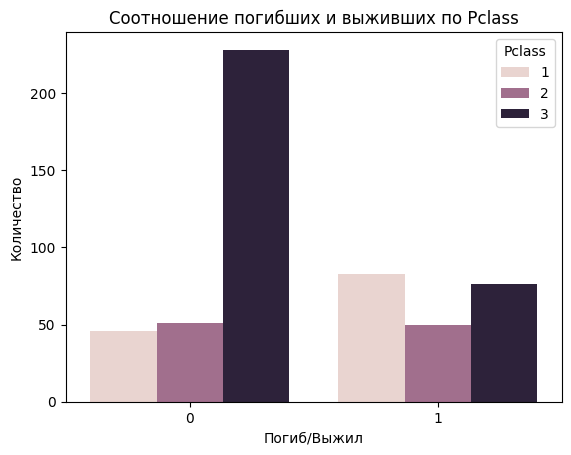

In [12]:
# Посмотрим на зависимость класса от целевой переменной
sns_countplot('Survived', 'Pclass', data_train)

Выживаемость в более высоких классах выше, чем в низких

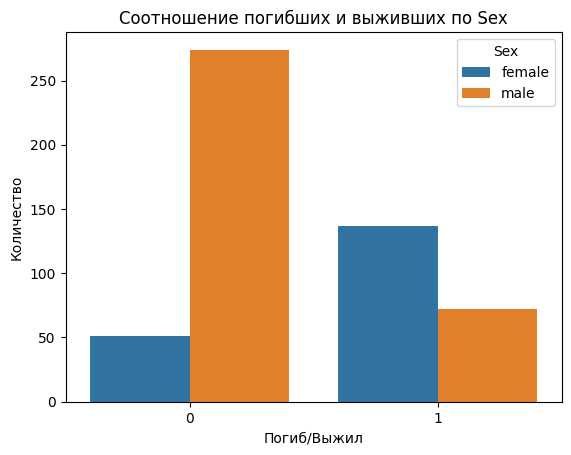

In [13]:
# Зависимость выживыемости от пола
sns_countplot('Survived', 'Sex', data_train)

Выживаемость женщин выше, чем у мужчин

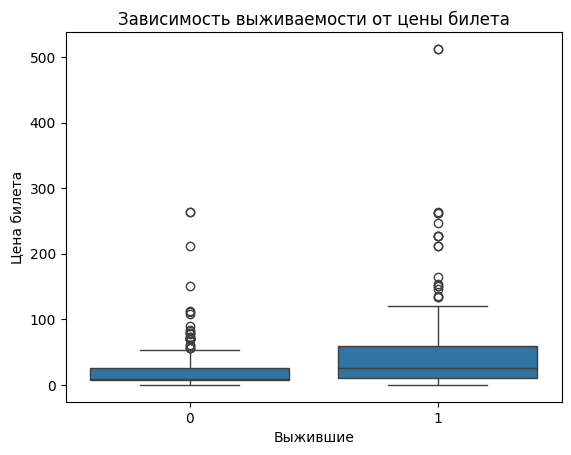

In [14]:
plt.figure()
sns.boxplot(x='Survived', y='Fare', data=data_train)
plt.xlabel('Выжившие')
plt.ylabel('Цена билета')
plt.title('Зависимость выживаемости от цены билета')
plt.show()

In [15]:
under_30_general = data_train[data_train['Age'] < 30]['Survived'].count()
under_30_survived = data_train[(data_train['Age'] < 30) & (data_train['Survived'] == 1)]['Survived'].count()
under_60_general = data_train[(data_train['Age'] > 30) & (data_train['Age'] < 60)]['Survived'].count()
under_60_survived = data_train[(data_train['Age'] > 30) & (data_train['Age'] < 60) & (data_train['Survived'] == 1)]['Survived'].count()
after_60_general = data_train[data_train['Age'] > 60]['Survived'].count()
after_60_survived = data_train[(data_train['Age'] > 60) & (data_train['Survived'] == 1)]['Survived'].count()
fraction_under_30 = under_30_survived / under_30_general
fraction_under_60 = under_60_survived / under_60_general
fraction_after_60 = after_60_survived / after_60_general
print(f"Количество выживших до 30 лет: {under_30_survived}")
print(f"Доля выживших до 30 лет: {fraction_under_30}")
print(f"Количество выживших между 30 и 60 лет: {under_60_survived}")
print(f"Доля выживших между 30 и 60 лет: {fraction_under_60}")
print(f"Количество выживших после 60 лет: {under_30_survived}")
print(f"Доля выживших после 60 лет: {fraction_after_60}")

Количество выживших до 30 лет: 97
Доля выживших до 30 лет: 0.41452991452991456
Количество выживших между 30 и 60 лет: 70
Доля выживших между 30 и 60 лет: 0.4268292682926829
Количество выживших после 60 лет: 97
Доля выживших после 60 лет: 0.23076923076923078


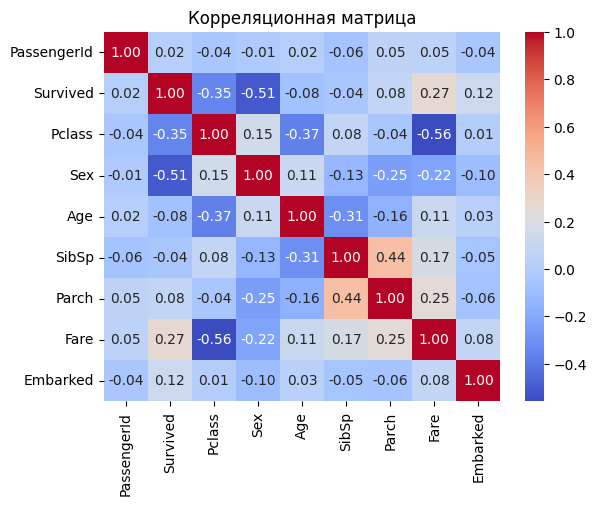

In [16]:
# Посмотрим коррелирующие признаки
data_matrix = data_train.copy()

decoder_sex = perform_change(data_matrix['Sex'])
decoder_embarked = perform_change(data_matrix['Embarked'])

matrix = data_matrix.drop(['Name', 'Cabin', 'Ticket'], axis=1).corr()

plt.figure()
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()

### Обработка данных

In [17]:
knnimpute_data = data_train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']].copy()

# Закодируем категориальные столбцы
decoder_sex = perform_change(knnimpute_data['Sex'])
decoder_embarked = perform_change(knnimpute_data['Embarked'])

knn = KNNImputer(n_neighbors=5, weights='distance')

scaler = StandardScaler()

knnimpute_data = scaler.fit_transform(knnimpute_data) # стандартизируем

knnimpute_data_imputed_temp = knn.fit_transform(knnimpute_data) # заполняем

knnimpute_data = scaler.inverse_transform(knnimpute_data_imputed_temp)

knnimpute_data = pd.DataFrame(knnimpute_data)
knnimpute_data = knnimpute_data[[3]].astype(int)

data_train['Age'] = knnimpute_data.values

In [18]:
knnimpute_data = data_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']].copy()

# Закодируем категориальные столбцы
decoder_sex = perform_change(knnimpute_data['Sex'])
decoder_embarked = perform_change(knnimpute_data['Embarked'])

knnimpute_data = scaler.fit_transform(knnimpute_data) # стандартизируем

knnimpute_data_imputed_temp = knn.fit_transform(knnimpute_data) # заполняем

knnimpute_data = scaler.inverse_transform(knnimpute_data_imputed_temp)

knnimpute_data = pd.DataFrame(knnimpute_data)
knnimpute_data = knnimpute_data[[2]].astype(int)

data_test['Age'] = knnimpute_data.values

In [19]:
data_train.drop(['Name', 'Cabin', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [20]:
data_test.drop(['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

In [21]:
decoder_sex = perform_change(data_train['Sex'])
decoder_emb = perform_change(data_train['Embarked'])

In [22]:
data_test.replace(np.nan, data_test['Embarked'].mode()[0], inplace=True)

In [23]:
decoder_sex_t = perform_change(data_test['Sex'])
decoder_emb_t = perform_change(data_test['Embarked'])

In [24]:
values_of_sigmaclip = sigmaclip(data_train['Fare'], low=1, high=4)

print(f"Нижняя граница Fare: {values_of_sigmaclip.lower}")
print(f"Верхняя граница Fare: {values_of_sigmaclip.upper}")

data_train = data_train[data_train['Fare'].isin(values_of_sigmaclip.clipped)]

Нижняя граница Fare: -0.8014583929911474
Верхняя граница Fare: 123.35064276961627


In [25]:
data_train = data_train[(data_train['Fare'] != 0) & (data_train['Age'] != 0)]

In [26]:
columns_to_scale = ['Age', 'Fare']
data_st = data_train[columns_to_scale]
data_scaled = scaler.fit_transform(data_st)
data_train[columns_to_scale] = data_scaled

In [27]:
data_st_t = data_test[columns_to_scale]
data_scaled_t = scaler.fit_transform(data_st_t)
data_test[columns_to_scale] = data_scaled_t

In [28]:
print(data_train.isna().sum())
print()
print(data_train.dtypes)

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Survived      int64
Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked      int64
dtype: object


In [29]:
print(data_test.isna().sum())
print()
print(data_test.dtypes)

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

PassengerId      int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked         int64
dtype: object


In [30]:
x = data_train.drop(columns=['Survived'])
y = data_train['Survived']

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### Логистическая регрессия

In [32]:
# сетка параметров
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

logistic_regression = LogisticRegression()

# объект для перекрестной проверки с поиском по сетке
grid_search = GridSearchCV(logistic_regression, param_grid, cv=10, scoring='roc_auc')

# Обучение модели на обработанных данных
grid_search.fit(x_train, y_train)

best_logistic_regression = grid_search.best_estimator_

y_pred = best_logistic_regression.predict(x_test)

y_pred_proba = best_logistic_regression.predict_proba(x_test)

roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.862609040444092


### Метод ближайших соседей

In [33]:
# сетка параметров 
param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 
              'weights': ['uniform', 'distance']}

knn = KNeighborsClassifier()

grid_search_knn = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc')

grid_search_knn.fit(x_train, y_train)

best_knn = grid_search_knn.best_estimator_

y_pred_knn = best_knn.predict(x_test)

y_pred_knn_proba = best_knn.predict_proba(x_test)

roc_auc_knn = roc_auc_score(y_test, y_pred_knn_proba[:, 1])
print("ROC-AUC Score for KNN:", roc_auc_knn)

ROC-AUC Score for KNN: 0.8711340206185567


### Наивный байесовский классификатор

In [34]:
naive_bayes = GaussianNB()

naive_bayes.fit(x_train, y_train)

y_pred_nb = naive_bayes.predict_proba(x_test)

roc_auc_nb = roc_auc_score(y_test, y_pred_nb[:, 1])
print("ROC-AUC Score for Naive Bayes:", roc_auc_nb)

ROC-AUC Score for Naive Bayes: 0.8296986518636004


### Дискриминантный анализ

In [35]:
# сетки параметров для перекрестной проверки
param_grid = {'solver': ['svd', 'lsqr', 'eigen']}

lda = LinearDiscriminantAnalysis()

grid_search = GridSearchCV(lda, param_grid, cv=10, scoring='roc_auc')

grid_search.fit(x_train, y_train)

best_lda = grid_search.best_estimator_
y_pred = best_lda.predict_proba(x_test)
roc_auc = roc_auc_score(y_test, y_pred[:, 1])
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.8641950832672483


### Машина опорных векторов

In [36]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]}

svm = SVC(probability=True)

grid_search = GridSearchCV(svm, param_grid, cv=10, scoring='roc_auc')

grid_search.fit(x_train, y_train)

best_svm = grid_search.best_estimator_
y_pred = best_svm.predict_proba(x_test)

roc_auc = roc_auc_score(y_test, y_pred[:, 1])
print("ROC-AUC Score:", roc_auc)


ROC-AUC Score: 0.8705392545598731


### Отбор информативных признаков

##### Для отбора признаков

In [ ]:
X = data_train.drop('Survived', axis=1)
Y = data_train['Survived']

#### Метод фильтрации

In [ ]:
# Оценка важности признаков
selector = SelectKBest(mutual_info_classif, k=4) # Выберем 5 наиболее информативных признаков
X_new = selector.fit_transform(X, Y)

selected_features_idx = selector.get_support(indices=True)

selected_features_names = X.columns[selected_features_idx]

print("Отобранные признаки:")
print(selected_features_names.tolist())

#### Метод обертки (с логистической регрессией)

In [ ]:
# Создание объекта с моделью
rfe = RFE(estimator=logistic_regression, n_features_to_select=4)

# применение и получение новых признаков
X_rfe = rfe.fit_transform(X, Y)

feature_ranking = rfe.ranking_

# оценка производительности
logistic_regression.fit(X_rfe, Y)

# отбор
selected_features_indexes = rfe.support_
selected_features_names = X.columns[selected_features_indexes]

print(selected_features_names.tolist())

Перед проверкой на модели

In [ ]:
x = data_train[selected_features_names.tolist()] 
y = data_train['Survived']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#### Сэмплирование

In [ ]:
x = data_train.drop(columns=['Survived'])  
y = data_train['Survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
x_train, y_train = ros.fit_resample(x_train, y_train)

### Применим алгоритм логистической регрессии к тестовой выборке

In [ ]:
data_test['Survived'] = np.nan

In [ ]:
x_test_t = data_test.drop(['PassengerId', 'Survived'], axis=1)

In [ ]:
y_pred_test = best_logistic_regression.predict_proba(x_test_t)

In [ ]:
data_test['Survived'] = y_pred_test[:, 1]

In [ ]:
data_test_response = data_test[['PassengerId', 'Survived']]

In [ ]:
data_test_response.to_csv('response.csv', index=False)